## Intro

This notebook is my prelimiary dive into **Natural Language Processing (NLP)**. I intend to utilize the information gained here to perform novel research on twitter data, for fintech applications.  

## Table of Contents
1. [Import Dependencies](#p1)
2. [Unpack Data](#p2)
3. [Preprocess Text](#p3)
4. [Analyse data](#p4)
5. [Split data](#p5)
6. [TF-IDF Vectoriser](#p6)
7. [Transform Dataset](#p7)
8. [Create and Evaluate Models](#p8)
    * [BernoulliNB Model](#p8-1)
    * [LinearSVC Model](#p8-2)
    * [Logistic Regression Model](#p8-3)
9. [Save Model](#p9)
10. [Deploy Model](#p10)

# <a name='p1'> Import Dependencies </a>

In [1]:
import numpy as np
import pandas as pd
import re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

# <a name='p2'> Unpack data </a>

In [2]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

## Remove unnecessary columns

In [3]:
df = df[['sentiment', 'text']]
df['sentiment'] = df['sentiment'].replace(4, 1)  # Change default value of 4 = positive to 1 = positive

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

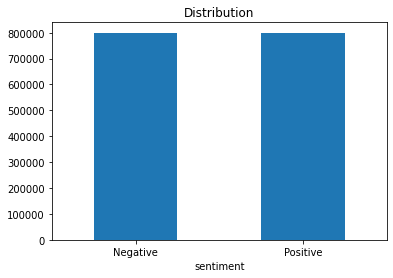

In [4]:
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution', legend=False)

ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

# <a name='p3'> Preprocess Text </a>

In [5]:
# Transform the data to lists
text, sentiment = list(df['text']), list(df['sentiment'])

In [6]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [7]:
from nltk.stem import WordNetLemmatizer

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer & Stemmer
    wordLemm = WordNetLemmatizer()
    
    # Define regex patterns
    urlPattern = r"((http://))[^ ]*|(https://)[^ ]*|( www\.[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URLs w/ 'URL'
        tweet = re.sub(urlPattern, ' URL', tweet)
        # Replace all emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        
        # Replace @USERNAME to 'USER'
        tweet = re.sub(userPattern, ' USER', tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            # Check if the word is a stopword
            if word not in stopwordlist:
                if len(word) > 1:
                    # Lemmatize the word
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word + ' ')
                    
        processedText.append(tweetwords)
        
    return processedText

In [8]:
import time
t = time.time()
processedtext = preprocess(text)

print(f'Time to preprocess text: {round(time.time() - t)} seconds')


Time to preprocess text: 174 seconds


# <a name='p4'> Analyze Data </a>

### Visualize the processed text with word-clouds

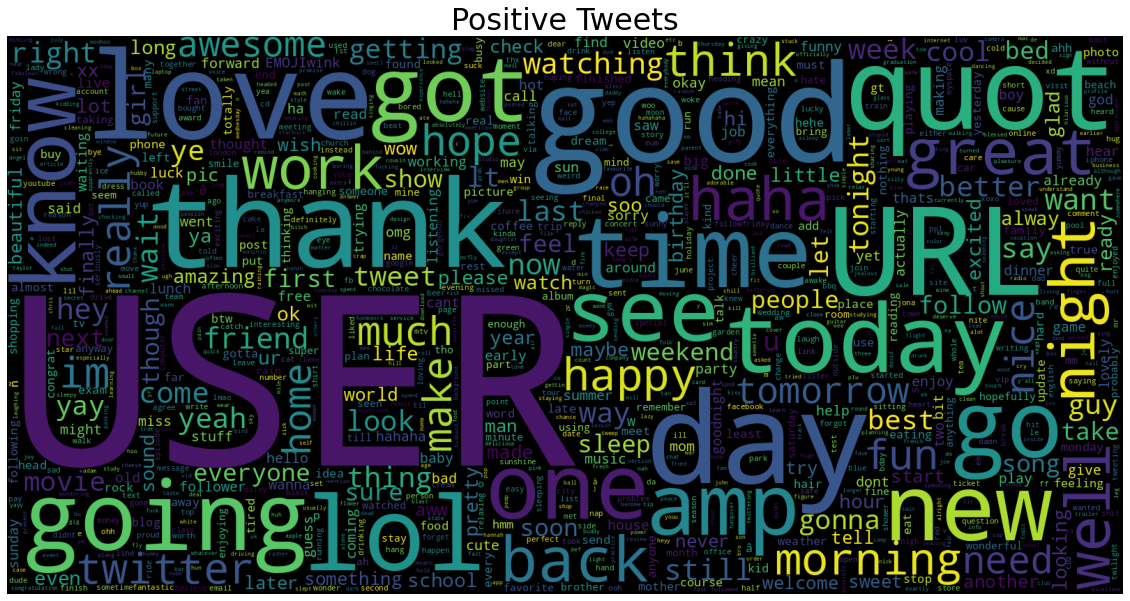

In [9]:
from wordcloud import WordCloud
# Positive tweets
data_pos = [txt for i, txt in enumerate(processedtext) if sentiment[i]]
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Positive Tweets", fontsize=30)
wc = WordCloud(max_words=1000, width=1600, height=800,
              collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

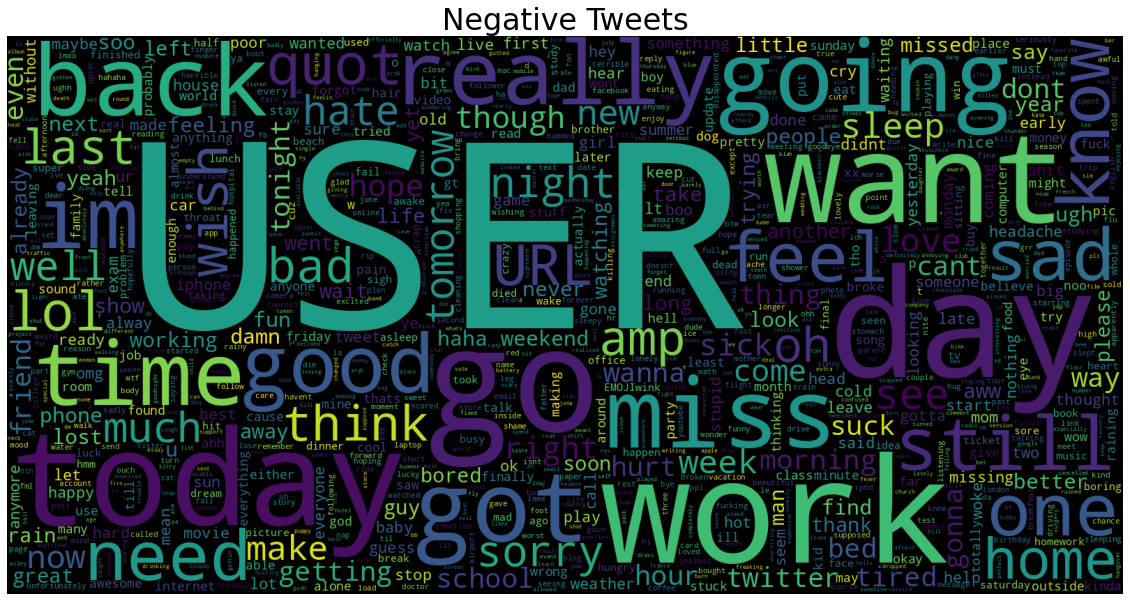

In [10]:
# Negative tweets
data_neg = [txt for i, txt in enumerate(processedtext) if not sentiment[i]]
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Negative Tweets", fontsize=30)
wc = WordCloud(max_words=1000, width=1600, height=800,
              collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

# <a name='p5'> Split Data </a>

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=0.05, random_state=42)

## <a name="p6"> TF-IDF Vectoriser</a>

Term frequency - inverse document frequency  
Numerical statistic that reflects how important a word is to a document in a collection.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x_train)

print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


## <a name = "p7"> Transform dataset into matrix of TF-IDF Features <a/>

In [13]:
X_train = vectoriser.transform(x_train)
X_test = vectoriser.transform(x_test)


In [14]:
X_train[0][0]

<1x500000 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

## <a name="p8"> Create and test models </a>
- Bernouli Naive Bayes (BernoulliNB)
- Linear Support Vector Classification (LinearSVC)
- Logistic Regression (LR)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

def evalModel(model):
    
    # Predict y values on test
    y_pred = model.predict(X_test)
    
    # Print evaluation metrics for dataset
    print(classification_report(y_test, y_pred))
    
    # Compute and plot confusion matrix
    cf = confusion_matrix(y_test, y_pred)
    
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percs = ['{0:.2%}'.format(value) for value in cf.flatten() / np.sum(cf)]
    
    labels = [f'{l1}\n{l2}' for l1, l2 in zip(group_names, group_percs)]
    labels = np.asarray(labels).reshape(2, 2)
    
    sns.heatmap(cf, annot=labels, cmap='Blues', fmt='',
               xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)

## <a name='p8-1'> BernoulliNB </a>

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     39999
           1       0.79      0.81      0.80     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



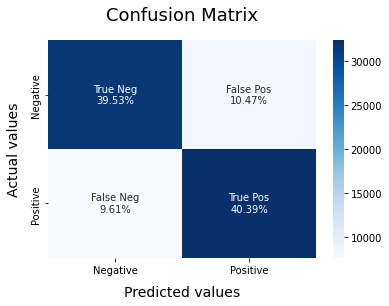

In [16]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB(alpha = 2)
bnb.fit(X_train, y_train)
evalModel(bnb)

## <a name='p8-2'> LinearSVC </a>

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39999
           1       0.80      0.81      0.81     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



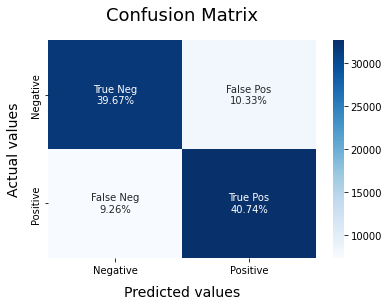

In [17]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)
evalModel(svc)

## <a name='p8-3'> Logistic Regression </a>

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39999
           1       0.81      0.83      0.82     40001

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



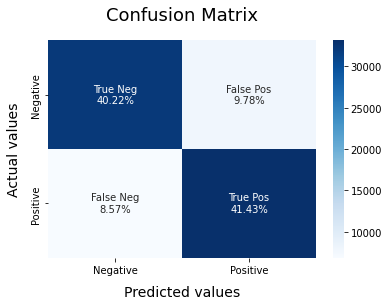

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C = 2, max_iter = 1000, n_jobs = -1)
logreg.fit(X_train, y_train)
evalModel(logreg)

# <a name='p9'> Save Model & Vectoriser </a>



In [19]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(logreg, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(bnb, file)
file.close()

# <a name='p10'> Deploy Model </a>

In [20]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('./vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('./Sentiment-LR.pickle', 'rb')
    logreg = pickle.load(file)
    file.close()
    
    return vectoriser, logreg

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    vectoriser, logreg = load_models()
    
    # Text to classify should be in a list.
    text = ["I LOVE data science!",
            "Boy do I hate Mondays",
            "I hate Mondays, but I sure do love lasagne"]
    
    df = predict(vectoriser, logreg, text)
    print(df.head())

                                         text sentiment
0                        I LOVE data science!  Positive
1                       Boy do I hate Mondays  Negative
2  I hate Mondays, but I sure do love lasagne  Positive
